# Win prediction for League of Legends games
# Logistic Regression
In this notebook we implement a logistic regression model to predict the outcome of a League of Legends match based purely on the team composition.

The input for this notebook is featureslabels.csv, which is a dataframe where each row is a match, and the columns are 'BlueWin' (1 if blue won, 0 if red won) together with the champions one-hot encoded if they are on the blue team, and -1 hot-encoded if they are on the red team.

### TO DO:

1. Clean up unnecessary parts of notebook
2. Organise into sections


### 1. Import packages and data

In [1]:
"""
@author: Mark Bugden
August/September 2022

Part of a ML project in predicting win rates for League of Legends games based on team composition.
Current update available on GitHub: https://github.com/Mark-Bugden
"""

# Import necessary packages
import requests
import pandas as pd
from ratelimit import limits, sleep_and_retry
import pickle
import math
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import numpy as np



from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score


# This gives us a progress bar for longer computations. 
from tqdm.notebook import tqdm
# To use it, just wrap any iterable with tqdm(iterable).
# Eg: 
# for i in tqdm(range(100)):
#     ....

# Here are the tiers and divisions
tier_list = ['DIAMOND', 'PLATINUM', 'GOLD', 'SILVER', 'BRONZE', 'IRON']
division_list = ['I', 'II', 'III', 'IV']

# Load the champion information
champion_url = 'http://ddragon.leagueoflegends.com/cdn/12.14.1/data/en_US/champion.json'
r = requests.get(champion_url)
json_data = r.json()
champion_data = json_data['data']

champions = list(champion_data.keys())
num_champs = len(champions)

# For some reason Fiddlesticks is listed as FiddleSticks in some of the other data. To avoid problems like this, I will convert all champion names to lowercase
champions = [champ.lower() for champ in champions]


champ_to_num = {k: v for v, k in enumerate(champions)}
num_to_champ = {v: k for v, k in enumerate(champions)}

# We can get champion information by accessing the champion_data dict
# Eg:
# champion_data['Zyra']


# One hot encode a list of champions
def onehotencodechampions(champs):
    ''' One hot encodes a list of champions.
    
    
    '''
    integer_encoded = [champ_to_num[champ] for champ in champs]
    onehot_encoded = [0] * len(champions)
    for value in integer_encoded:
        onehot_encoded[value] = 1
    return onehot_encoded

In [2]:
df = pd.read_csv('../Preprocessing/featureslabels.csv', index_col=0)
df.head()

,BlueWin,championName_aatrox,championName_ahri,championName_akali,championName_akshan,championName_alistar,championName_amumu,championName_anivia,championName_annie,championName_aphelios,...,championName_yone,championName_yorick,championName_yuumi,championName_zac,championName_zed,championName_zeri,championName_ziggs,championName_zilean,championName_zoe,championName_zyra
matchId,,,,,,,,,,,,,,,,,,,,,
EUN1_2670740139,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EUN1_2671611908,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
EUN1_2671704791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EUN1_2672157655,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,-1,0,0,0
EUN1_2673422946,0,0,0,0,0,0,0,0,0,0,...,-1,0,1,0,0,0,0,0,0,0


In [3]:
X = df.drop('BlueWin', axis=1).values
y = df['BlueWin'].values

In [4]:
print(X.shape)
print(y.shape)

(21333, 161)
(21333,)


In [5]:
# Split the data into training, validation, and test data


#train_features = features[0 :math.floor(0.7*len(matches))]
#train_labels = labels[0 : math.floor(0.7*len(matches))]

#validation_features = features[math.floor(0.7*len(matches)) : math.floor(0.9*len(matches))]
#validation_labels = labels[math.floor(0.7*len(matches)) : math.floor(0.9*len(matches))]

#test_features = features[math.floor(0.9*len(matches)) : ]
#test_labels = labels[math.floor(0.9*len(matches)) : ]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### 3. Build and train the model

In [6]:

# Build a logistic regression model
logreg = LogisticRegression()


# We want to use cross validation on our model performance metrics so they are less dependent on the way we split our data. 
# We use KFold to split our dataset into K folds, and train the model K times using each fold as a test set.
# We then calculate our performance metrics for each of the trained models, giving use the (K-fold) cross-validation performance metrics.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=kf, scoring='roc_auc')



# Train the model
logreg.fit(X_train, y_train)


# Make predictions on the test set
y_pred = logreg.predict(X_test)
y_pred_probs = logreg.predict_proba(X_test)[:, 1]

In [7]:
# Mean
print(f'The mean roc auc is: {logreg_cv.mean():.1%}')

# 95% confidence interval
print(f'The 95% confidence interval is: {np.quantile(logreg_cv, [0.025, 0.975])}')



The mean roc auc is: 53.8%
The 95% confidence interval is: [0.53060058 0.54366399]


### 5. Evaluate the network on the training and test data

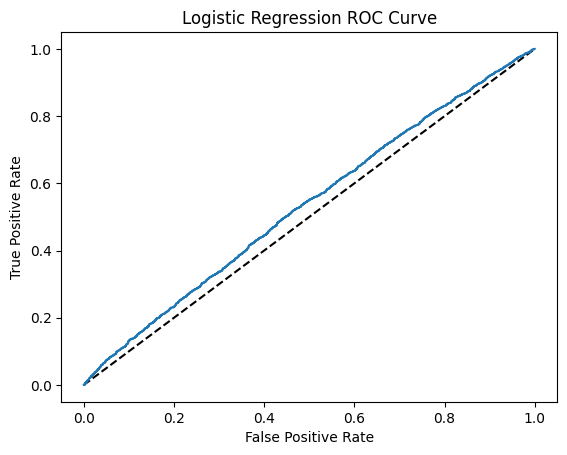

In [8]:
# Visualise the ROC curve for the trained model

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [9]:
print(roc_auc_score(y_test, y_pred_probs))

0.533721301020408


This actually isn't terrible. If we were just plain guessing, the roc auc score would be 0.5, so anything higher than that represents an improvement upon random chance. 

### 6. Make predictions

We will now predict the winner of a random match of champions. 

In [10]:
# Pick a random selection of champions

pred_champs = np.random.choice(161, 10, replace=False)
pred_blue_champs = pred_champs[0:5]
pred_red_champs = pred_champs[5:]

pred_blue_team = [num_to_champ[champ] for champ in pred_blue_champs]
pred_red_team = [num_to_champ[champ] for champ in pred_red_champs]

print('Blue team is: ', pred_blue_team)
print('Red team is: ', pred_red_team)

Blue team is:  ['kayle', 'samira', 'jinx', 'yuumi', 'syndra']
Red team is:  ['aatrox', 'twistedfate', 'hecarim', 'lucian', 'lux']


In [11]:
pred_features = []

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

pred_features.append([sum(value) for value in zip(pred_blue_team_enc, pred_red_team_enc)])


pred_features = np.array(pred_features)

pred_outcome = logreg.predict(pred_features)
pred_proba = logreg.predict_proba(pred_features)[:, 1]

print(pred_outcome)
print(pred_proba)

[1]
[0.58687946]


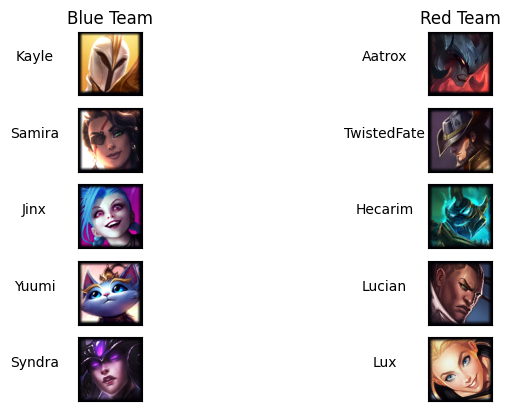

BLUE team is the predicted winner 

Blue win probability:  58.7%
Red win probability:  41.3%


In [12]:
from matplotlib.image import imread

imgarrays = [imread(file) for file in glob.glob('../img/Champion icons/*.png')]
champ_list = [champ for champ in champion_data.keys()]



fig, ax = plt.subplots(5,3)

for i in range(5):
    ax[i,0].imshow(imgarrays[champ_to_num[pred_blue_team[i]]])
    ax[i,0].set_ylabel(champ_list[champ_to_num[pred_blue_team[i]]], rotation=0, fontsize='medium', labelpad=28)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    
for i in range(5):
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    ax[i,1].axis('off')

for i in range(5):
    ax[i,2].imshow(imgarrays[champ_to_num[pred_red_team[i]]])
    ax[i,2].set_ylabel(champ_list[champ_to_num[pred_red_team[i]]], rotation=0, size='medium', labelpad=28)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    
ax[0,0].set_title('Blue Team')
ax[0,2].set_title('Red Team')

plt.show()


# The predicted winner
if (pred_outcome[0]==1):
    print('BLUE team is the predicted winner', '\n')
    print(f'Blue win probability:  {pred_proba[0]:.1%}')
    print(f'Red win probability:  {1-pred_proba[0]:.1%}')
    
elif (pred_outcome[0]==0):
    print('RED team is the predicted winner', '\n')
    print(f'Blue win probability: {pred_proba[0]:.1%}')
    print(f'Red win probability: {1-pred_proba[0]:.1%}')
    
else:
    print('Something went wrong!', '\n')
    print(f'Blue win probability:  {pred_proba[0]:.1%}')
    print(f'Red win probability:  {1-pred_proba[0]:.1%}')


In [13]:


pred_blue_team = ['sylas', 'gnar', 'xayah', 'shaco', 'nami']
pred_red_team = ['nautilus', 'jhin', 'neeko', 'masteryi', 'jax']

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

In [14]:
print('Blue team is: ', pred_blue_team)
print('Red team is: ', pred_red_team)

Blue team is:  ['sylas', 'gnar', 'xayah', 'shaco', 'nami']
Red team is:  ['nautilus', 'jhin', 'neeko', 'masteryi', 'jax']


In [15]:
pred_features = []

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

pred_features.append([sum(value) for value in zip(pred_blue_team_enc, pred_red_team_enc)])


pred_features = np.array(pred_features)

pred_outcome = logreg.predict(pred_features)
pred_proba = logreg.predict_proba(pred_features)[:, 1]

print(pred_outcome)
print(pred_proba)

[0]
[0.44700878]
